# 3d Object Detection Model 

In [7]:
import os
import cv2
from glob import glob
import numpy as np
import pandas as pd
from kitti_utils import *
import matplotlib.pyplot as plt
from parseTrackletXML import *
import pykitti
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Checking the Number of Files and Images within the drive 0015 folder

In [4]:
image_files = '../data/2011_09_26/2011_09_26_drive_0015_sync'
# Get the left and right images.
right_image_path = sorted(glob(os.path.join(image_files,'image_02/data/*.png')))
left_image_path = sorted(glob(os.path.join(image_files,'image_03/data/*.png')))

# Get LiDAR data
bin_paths = sorted(glob(os.path.join(image_files,'velodyne_points/data/*.bin')))

#Get GPS/Imu data
oxts_path = sorted(glob(os.path.join(image_files,r'oxts/data/*.txt')))

print(f'Number of right images: ',{len(right_image_path)})
print(f'Number of left images: ', {len(left_image_path)})
print(f'Number of LiDAR' ,{len(bin_paths)})
print(f'Number of GPS data', {len(oxts_path)})

Number of right images:  {297}
Number of left images:  {297}
Number of LiDAR {297}
Number of GPS data {297}


### Folder Paths

In [8]:
xml_file = '../data/2011_09_26/tracklet_labels.xml'
basedir = '../data/'

### Load Dataset using pykitti

In [9]:
def load_dataset(date,drive,calibrated=False,frame_range=None):
    '''
    Load the dataset from the KITTI raw dataset with the help of pykitti library
    :param date: Date of the drive
    :param drive: Drive number
    :param calibrated: If the dataset is calibrated
    :param frame_range: Range of frames to load
    :return: dataset
    '''

    dataset = pykitti.raw(basedir,date,drive)
    if calibrated:
        dataset._load_calib()
    np.set_printoptions(precision=4, suppress=True)
    print('\nDrive: ' + str(dataset.drive))
    print('\nFrame range: ' + str(dataset.frames))

    if calibrated:
        print('\nIMU-to-Velodyne transformation:\n' + str(dataset.calib.T_velo_imu))
        print('\nGray stereo pair baseline: [m]\n' + str(dataset.calib.b_gray))
        print('\nRGB stereo pair baseline [m]:\n' + str(dataset.calib.T_velo_imu))
    return dataset

In [10]:
date = '2011_09_26'
drive = '0015'
dataset = load_dataset(date,drive,True)


Drive: 2011_09_26_drive_0015_sync

Frame range: None

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline: [m]
0.537150600500771

RGB stereo pair baseline [m]:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]


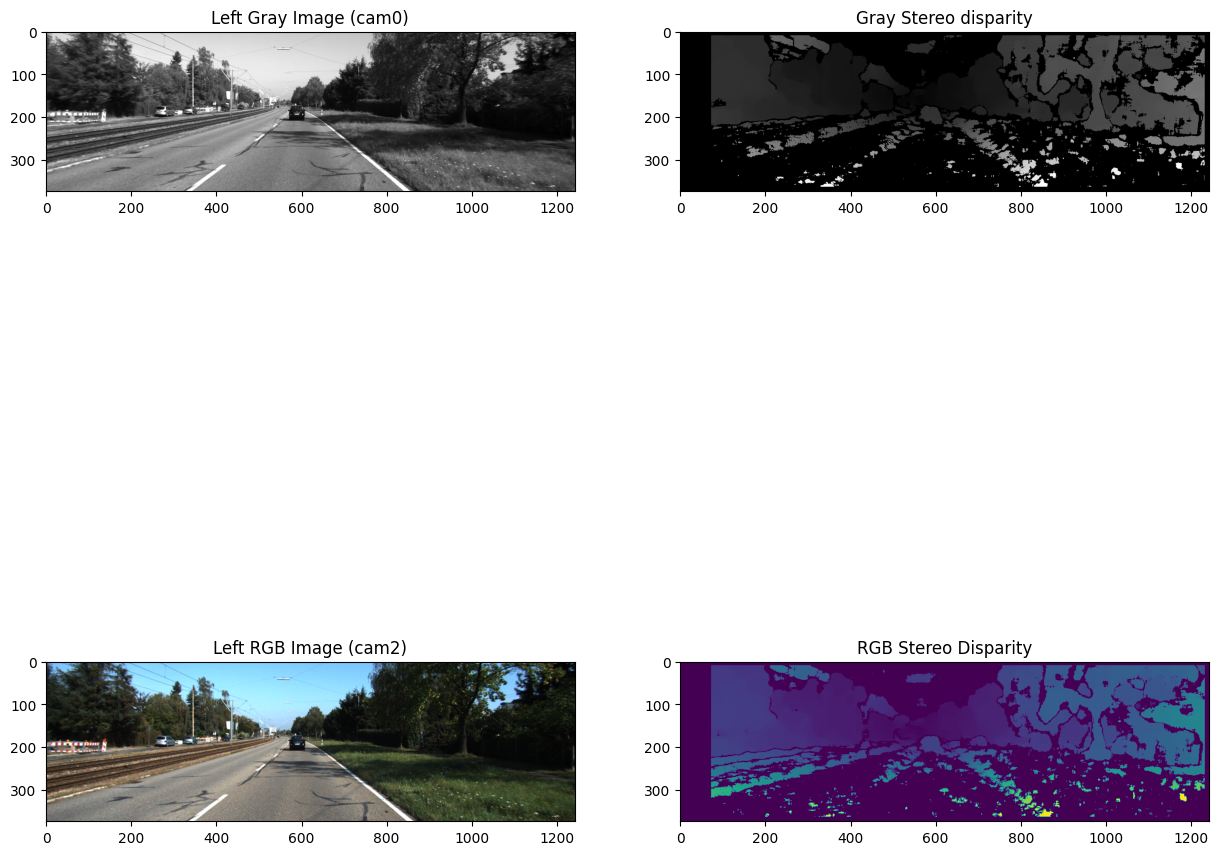

In [11]:
first_rgb = dataset.get_rgb(0)
first_gray = dataset.get_gray(0)
stereo = cv2.StereoBM_create()
disp_gray = stereo.compute(np.array(first_gray[0]), np.array(first_gray[1]))
disp_rgb = stereo.compute(cv2.cvtColor(np.array(first_rgb[0]),cv2.COLOR_RGB2GRAY),
                          cv2.cvtColor(np.array(first_rgb[1]),cv2.COLOR_RGB2GRAY))
f, ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].imshow(first_gray[0],cmap='gray')
ax[0,0].set_title('Left Gray Image (cam0)')

ax[0,1].imshow(disp_gray,cmap='gray')
ax[0,1].set_title('Gray Stereo disparity')

ax[1,0].imshow(first_rgb[0])
ax[1,0].set_title('Left RGB Image (cam2)')

ax[1,1].imshow(disp_rgb)
ax[1,1].set_title('RGB Stereo Disparity')

plt.show()


### Load the annotations /  labels and store them in a dataframe

In [12]:
def load_tracklets(n_frames, xml_path):
    '''
    Load the tracklets from the xml file
    :param n_frames: Number of frames
    :param xml_path: Path to the xml file
    :return: frame_tracklets, frame_tracklets_types
    '''
    tracklets = parseXML(xml_path)
    frame_tracklets = {}
    frame_tracklets_types = {}
    for i in range(n_frames):
        frame_tracklets[i] = []
        frame_tracklets_types[i] = []

    for i, tracklet in enumerate(tracklets):
        h,w,l = tracklet.size
        #print(h,w,l)
        trackletBox = np.array([[-l / 2, -l / 2, l / 2, l / 2, -l / 2, -l / 2, l / 2, l / 2],
            [w / 2, -w / 2, -w / 2, w / 2, w / 2, -w / 2, -w / 2, w / 2],
            [0.0, 0.0, 0.0, 0.0, h, h, h, h]])
        for translation,rotation,state,occlusion,truncation,amtOcclusion,amtBorders,absoluteFrameNumber in tracklet:
            if truncation not in (TRUNC_IN_IMAGE, TRUNC_TRUNCATED):
                continue
            yaw = rotation[2]   # other rotations are 0 in all xml files I checked
            assert np.abs(rotation[:2]).sum() == 0, 'object rotations other than yaw given!'
            rotMat = np.array([\
                [np.cos(yaw), -np.sin(yaw), 0.0], \
                [np.sin(yaw),  np.cos(yaw), 0.0], \
                [0.0,0.0, 1.0]])
            cornerPosInVelo = np.dot(rotMat, trackletBox) + np.tile(translation, (8,1)).T
            #print(frame_tracklets)
            frame_tracklets[absoluteFrameNumber] = frame_tracklets[absoluteFrameNumber] + [cornerPosInVelo]
            frame_tracklets_types[absoluteFrameNumber] = frame_tracklets_types[absoluteFrameNumber]+[tracklet.objectType]
   
    return (frame_tracklets, frame_tracklets_types)

#### Printing out the dictionary that contains the labels and the dimensions for the boxes for the images

In [13]:
tracklet_rects, tracklet_types = load_tracklets(len(list(dataset.velo)),'../data/{}/tracklet_labels.xml'.format(date))
print(tracklet_rects[296],tracklet_types[296])

parsing tracklet file ../data/2011_09_26/tracklet_labels.xml
file contains 36 tracklets
loaded 36 tracklets
[array([[29.9692, 29.9632, 34.4632, 34.4692, 29.9692, 29.9632, 34.4632,
        34.4692],
       [ 0.7701, -0.8588, -0.8753,  0.7536,  0.7701, -0.8588, -0.8753,
         0.7536],
       [-1.4481, -1.4481, -1.4481, -1.4481,  0.1739,  0.1739,  0.1739,
         0.1739]])] ['Car']


### Plotting the 3D boxes for LiDAR points

In [17]:
colors = {
    'Car': 'b',
    'Tram': 'r',
    'Cyclist': 'g',
    'Van': 'c',
    'Truck': 'm',
    'Pedestrian': 'y',
    'Sitter': 'k'
}
axes_limits = [
    [-20, 80], # X axis range
    [-20, 20], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']

def draw_box(pyplot_axis, vertices, axes=[0, 1, 2], color='black'):
    """
    Draws a bounding 3D box in a pyplot axis.
    
    Parameters
    ----------
    pyplot_axis : Pyplot axis to draw in.
    vertices    : Array 8 box vertices containing x, y, z coordinates.
    axes        : Axes to use. Defaults to `[0, 1, 2]`, e.g. x, y and z axes.
    color       : Drawing color. Defaults to `black`.
    """
    vertices = vertices[axes, :]
    connections = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # Lower plane parallel to Z=0 plane
        [4, 5], [5, 6], [6, 7], [7, 4],  # Upper plane parallel to Z=0 plane
        [0, 4], [1, 5], [2, 6], [3, 7]  # Connections between upper and lower planes
    ]
    for connection in connections:
        pyplot_axis.plot(*vertices[:, connection], c=color, lw=0.5)

def display_frame_statistics(dataset, tracklet_rects, tracklet_types, frame, points=0.2):
    """
    Displays statistics for a single frame. Draws camera data, 3D plot of the lidar point cloud data and point cloud
    projections to various planes.
    
    Parameters
    ----------
    dataset         : `raw` dataset.
    tracklet_rects  : Dictionary with tracklet bounding boxes coordinates.
    tracklet_types  : Dictionary with tracklet types.
    frame           : Absolute number of the frame.
    points          : Fraction of lidar points to use. Defaults to `0.2`, e.g. 20%.
    """
    dataset_gray = list(dataset.gray)
    dataset_rgb = list(dataset.rgb)
    dataset_velo = list(dataset.velo)
    
    print('Frame timestamp: ' + str(dataset.timestamps[frame]))
    # Draw camera data
    f, ax = plt.subplots(2, 2, figsize=(15, 5))
    ax[0, 0].imshow(dataset_gray[frame][0], cmap='gray')
    ax[0, 0].set_title('Left Gray Image (cam0)')
    ax[0, 1].imshow(dataset_gray[frame][1], cmap='gray')
    ax[0, 1].set_title('Right Gray Image (cam1)')
    ax[1, 0].imshow(dataset_rgb[frame][0])
    ax[1, 0].set_title('Left RGB Image (cam2)')
    ax[1, 1].imshow(dataset_rgb[frame][1])
    ax[1, 1].set_title('Right RGB Image (cam3)')
    plt.show()

    points_step = int(1. / points)
    point_size = 0.01 * (1. / points)
    velo_range = range(0, dataset_velo[frame].shape[0], points_step)
    velo_frame = dataset_velo[frame][velo_range, :]      
    def draw_point_cloud(ax, title, axes=[0, 1, 2], xlim3d=None, ylim3d=None, zlim3d=None):
        """
        Convenient method for drawing various point cloud projections as a part of frame statistics.
        """
        ax.scatter(*np.transpose(velo_frame[:, axes]), s=point_size, c=velo_frame[:, 3], cmap='gray')
        ax.set_title(title)
        ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
        ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
        if len(axes) > 2:
            ax.set_xlim3d(*axes_limits[axes[0]])
            ax.set_ylim3d(*axes_limits[axes[1]])
            ax.set_zlim3d(*axes_limits[axes[2]])
            ax.set_zlabel('{} axis'.format(axes_str[axes[2]]))
        else:
            ax.set_xlim(*axes_limits[axes[0]])
            ax.set_ylim(*axes_limits[axes[1]])
        # User specified limits
        if xlim3d!=None:
            ax.set_xlim3d(xlim3d)
        if ylim3d!=None:
            ax.set_ylim3d(ylim3d)
        if zlim3d!=None:
            ax.set_zlim3d(zlim3d)
            
        for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
            draw_box(ax, t_rects, axes=axes, color=colors[t_type])
            
    # Draw point cloud data as 3D plot
    f2 = plt.figure(figsize=(15, 8))
    ax2 = f2.add_subplot(111, projection='3d')                    
    draw_point_cloud(ax2, 'Velodyne scan', xlim3d=(-10,30))
    plt.show()
    '''
    # Draw point cloud data as plane projections
    f, ax3 = plt.subplots(3, 1, figsize=(15, 25))
    draw_point_cloud(
        ax3[0], 
        'Velodyne scan, XZ projection (Y = 0), the car is moving in direction left to right', 
        axes=[0, 2] # X and Z axes
    )
    draw_point_cloud(
        ax3[1], 
        'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
        axes=[0, 1] # X and Y axes
    )
    draw_point_cloud(
        ax3[2], 
        'Velodyne scan, YZ projection (X = 0), the car is moving towards the graph plane', 
        axes=[1, 2] # Y and Z axes
    )
    plt.show()
    '''

Frame timestamp: 2011-09-26 13:12:03.968689


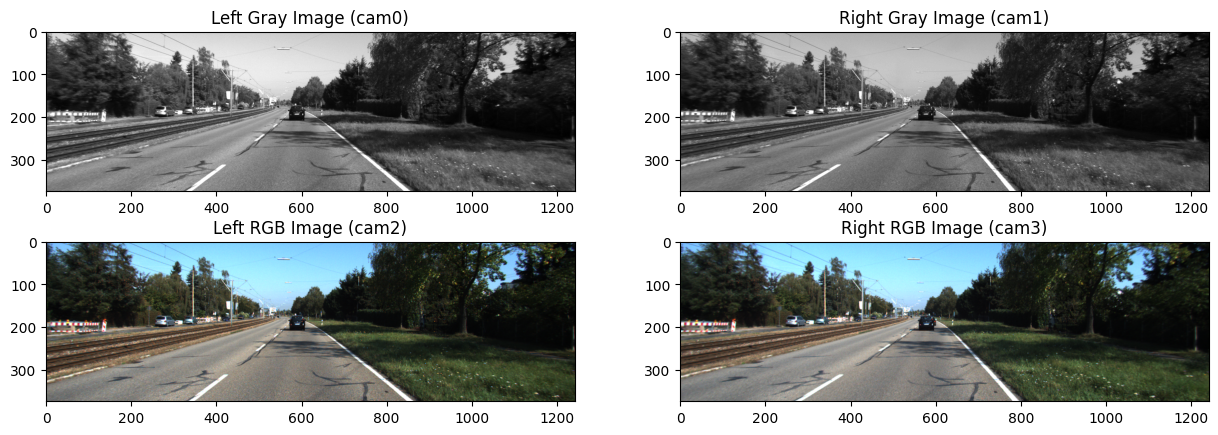

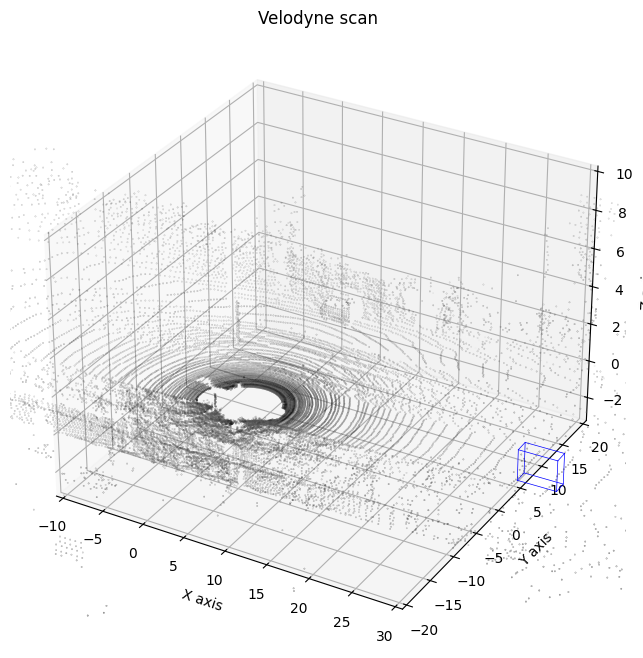

In [45]:
frame = 0
display_frame_statistics(dataset,tracklet_rects,tracklet_types,frame)

In [38]:
print(len(tracklet_types[200]))

6


In [44]:
for t_rects, t_type in zip(tracklet_rects[0], tracklet_types[0]):
            print(t_rects,t_type)

[[45.0373 44.9851 48.5252 48.5773 45.0373 44.9851 48.5252 48.5773]
 [22.0835 20.4563 20.3428 21.9701 22.0835 20.4563 20.3428 21.9701]
 [-1.2625 -1.2625 -1.2625 -1.2625  0.4535  0.4535  0.4535  0.4535]] Car
[[56.0829 56.126  59.6329 59.5898 56.0829 56.126  59.6329 59.5898]
 [22.1987 20.6956 20.7961 22.2992 22.1987 20.6956 20.7961 22.2992]
 [-1.0296 -1.0296 -1.0296 -1.0296  0.4911  0.4911  0.4911  0.4911]] Car
[[32.8212 32.8603 37.359  37.3199 32.8212 32.8603 37.359  37.3199]
 [ 1.6945  0.0661  0.174   1.8025  1.6945  0.0661  0.174   1.8025]
 [-1.3781 -1.3781 -1.3781 -1.3781  0.2439  0.2439  0.2439  0.2439]] Car


In [75]:
def extractBoxes(tracklet_rects,tracklet_types,frame):
    '''
    Extract the bounding boxes from the tracklet_rects and tracklet_types
    :param tracklet_rects: Dictionary with tracklet bounding boxes coordinates.
    :param tracklet_types: Dictionary with tracklet types.
    :param frame: Absolute number of the frame.
    :return: bounding_boxes, types
    '''
    bounding_boxes = []
    types = []
    for t_rects, t_type in zip(tracklet_rects[frame], tracklet_types[frame]):
        bounding_boxes.append(t_rects)
        types.append(t_type)
    return bounding_boxes, types
b,t = extractBoxes(tracklet_rects,tracklet_types,0)
t

['Car', 'Car', 'Car']

In [65]:
def extractImageDims(frame, xml_path):
    '''
    Extract the image dimensions from the xml file
    :param frames: Number of frames
    :param xml_path: Path to the xml file
    :return: image_dims
    '''
    tracklets = parseXML(xml_path)
    image_dims = []
    for i,tracklet in enumerate(tracklets):
        h,w,l = tracklet.size
        image_dims.append([h,w,l])
    return image_dims[frame]
        
extractImageDims(0,xml_file)

parsing tracklet file ../data/2011_09_26/tracklet_labels.xml
file contains 36 tracklets
loaded 36 tracklets


[1.7160122, 1.6280682, 3.5418346]

In [77]:
def getBoxDims(frame):
    b,t = extractBoxes(tracklet_rects,tracklet_types,frame)
    return [extractImageDims(frame,xml_file),b,t]

In [102]:
t = getBoxDims(0)
for i in range(len(t[1])):
    box = t[1][i]
    row_x_1 = box[0][0]
    row_x_2 = box[0][1]
    row_x_3 = box[0][2]
    row_y_1 = box[1][0]
    row_y_2 = box[1][1]
    row_y_3 = box[1][2]
    row_z_1 = box[2][0]
    row_z_2 = box[2][1]
    row_z_3 = box[2][2]
    masks = [row_x_1:row_x_3,row_y_1,row_y_2,row_y_3,row_z_1,row_z_2,row_z_3]
    print(row_x_1,row_x_2,row_x_3,row_y_1,row_y_2,row_y_3,row_z_1,row_z_2,row_z_3)
l,w,h = t[0]
typ = t[2][0]
typ

parsing tracklet file ../data/2011_09_26/tracklet_labels.xml
file contains 36 tracklets
loaded 36 tracklets
45.03726968397537 44.98514152775138 48.525160155651264 22.083485325434 20.456251869786065 20.342847955043244 -1.2625371217727661 -1.2625371217727661 -1.2625371217727661
56.082880774019706 56.12595133337927 59.63286528383613 22.198687728966163 20.695648909843353 20.796141820306033 -1.029607866172173 -1.029607866172173 -1.029607866172173
32.82124369892357 32.86031317776395 37.35901863104094 1.6945231904104827 0.06606619492104016 0.17399786152490193 -1.3780748844146729 -1.3780748844146729 -1.3780748844146729


'Car'

In [103]:
image = dataset.get_rgb(0)[0]


parsing tracklet file ../data/2011_09_26/tracklet_labels.xml
file contains 36 tracklets
loaded 36 tracklets


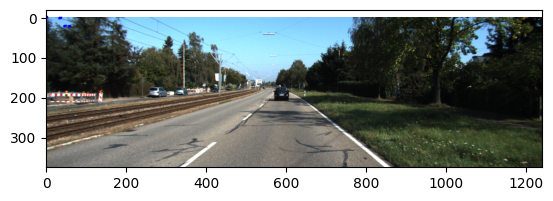

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already imported getBoxDims and have the necessary data
t = getBoxDims(0)
image = np.array(dataset.get_rgb(0)[0])  # Convert the Pillow image to a numpy array

# Create a plot with the image
plt.imshow(image)

# Plot the bounding boxes
for i in range(len(t[1])):
    box = t[1][i]
    box = t[1][i]
    x = [box[0][0] ,box[0][1], box[0][2]]
    y = [box[1][0],box[1][1], box[1][2]]
    z = [box[2][0],box[2][1], box[2][2]]
    
    plt.plot(x,y,z, color='b')  # Plot the rectangle

plt.show()  # Display the plot

